In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import warnings
import pickle
import seaborn as sns
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.feature_selection import RFECV
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from imblearn.combine import SMOTEENN
from collections import Counter
%matplotlib inline

In [90]:
def time_format(sec):
    return str(timedelta(seconds=sec))

def my_decorator(function_to_decorate):
    # Внутри себя декоратор определяет функцию-"обёртку". Она будет обёрнута вокруг декорируемой,
    # получая возможность исполнять произвольный код до и после неё.
    def the_wrapper_around_the_original_function():
        print("Я - код, который отработает до вызова функции")
        function_to_decorate() # Вызов самой функции
        print("А я - код, срабатывающий после")
    # Вернём эту функцию
    return the_wrapper_around_the_original_function

In [91]:
def time_it(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        return_value = func(*args, **kwargs)
        end = time.time()
        print('Время выполнения: {} секунды'.format(end-start))
        return return_value
    return wrapper

@time_it
def dummy_func(seconds_to_wait):
    time.sleep(seconds_to_wait)
    val = 'Функция спала ~{} секунды'.format(seconds_to_wait)
    return val

In [89]:
# Построение DataSet
def build_dataset_raw(churned_start_date='2019-01-01', 
                      churned_end_date='2019-02-01', 
                      inter_list=[(1,7),(8,14)],
                      raw_data_path='train/',
                      dataset_path='dataset/', 
                      mode='train'):
    
    start_t = time.time()
 
    samples = pd.read_csv('{}sample.csv'.format(raw_data_path), 
                          sep=';', 
                          chunksize=10000, 
                          na_values=['\\N', 'None'], 
                          encoding='utf-8')
    
    print('Run time (reading csv files): {}'.format(time_format(time.time()-start_t)))    
#-----------------------------------------------------------------------------------------------------    
    print('NO dealing with outliers, missing values and categorical features...')
#-----------------------------------------------------------------------------------------------------        
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом
    
    print('Creating dataset...')
    # Для каждой подвыборки пользователей будем создавать признаки и записывать в финальный DataSet
    for sample in samples:
        # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
        if mode == 'train':
            dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
        elif mode == 'test':
            dataset = sample.copy()[['user_id', 'level', 'donate_total']]

        # Пройдемся по всем источникам, содержащим "динамичекие" данные
        for file_name in ['payments', 'reports', 'abusers', 'logins', 'pings', 'sessions', 'shop']:
            df = pd.read_csv('{}.csv'.format(raw_data_path + file_name), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
            # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
            data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
            data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - 
                                    data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.days)
            df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

            # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
            features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
            print('Processing with features:', features)
            for feature in features:
                for i, inter in enumerate(inter_list):
                    inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)].\
                                    groupby('user_id')[feature].mean().reset_index().\
                                    rename(index=str, columns={feature: feature+'_{}'.format(i+1)})
                    df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

            # Добавляем построенные признаки в датасет
            dataset = pd.merge(dataset, df_features, how='left', on='user_id')

            print('Run time (calculating features): {}'.format(time_format(time.time()-start_t)))

        # Добавляем "статические" признаки
        profiles = pd.read_csv('{}profiles.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
        dataset = pd.merge(dataset, profiles, how='left', on='user_id')
    #---------------------------------------------------------------------------------------------------------------------------
        dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', mode='a', index=False)
        print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'.\
              format(dataset_path, time_format(time.time()-start_t)))

In [2]:
# # График зависимости показателя от предсказываемого значения
# def grafic(df, param, target, sample_val, wi, hi):
#     limit_bal_with_target_s = df[[param, TARGET_NAME]].sample(sample_val)
#     limit_bal_s = limit_bal_with_target_s[param]
#     limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
#     limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]
    
#     plt.figure(figsize=(wi, hi))

#     sns.kdeplot(limit_bal_target_0, shade=True, label='No good', color='g')
#     sns.kdeplot(limit_bal_target_1, shade=True, label='Good', color='r')

#     plt.xlabel(param)
#     plt.title(param + ' grouped by target variable')
#     plt.show()
#     return limit_bal_with_target_s, limit_bal_s, limit_bal_target_0, limit_bal_target_1

In [2]:
# Нормализация данных при помощи boxcox
def box_cox(param):
    data_t, lmbda = boxcox(param)
    plt.figure(figsize=(10,5))
    sns.kdeplot(param, shade=True, label='No default', color='g')
    plt.figure(figsize=(10,5))
    sns.kdeplot(data_t, shade=True, label='Default', color='r')
    return data_t, lmbda

In [4]:
# def hist_param(param, target, DataF, we, hi):
#     plt.figure(figsize=(we, hi))

#     sns.countplot(x=param, hue=target, data=DataF)
#     plt.title(param + ' grouped by target variable')
#     plt.legend(title='Target', loc='upper right')

#     plt.show() 

In [22]:
# Отчет обучения
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

In [5]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [6]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='./train/',
                  dataset_path='./dataset/', 
                  mode='train')

Run time (reading csv files): 0:00:00.072509
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:00:04.113507
Processing with features: ['reports_amt']
Run time (calculating features): 0:00:18.203542
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:00:59.384736
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 0:01:57.009816
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:02:45.906808
Processing with features: ['session_player', 'win_rate', 'kd', 'leavings_rate']
Run time (calculating features): 0:03:45.827251
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:04:39.489896
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 0:04:42.049573
Processing with features: ['trans_amt', 'pay_

Run time (calculating features): 0:45:46.546460
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 0:45:49.116823
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:45:54.451527
Processing with features: ['reports_amt']
Run time (calculating features): 0:46:07.072326
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:46:45.066519
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 0:47:36.978361
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:48:25.174853
Processing with features: ['session_player', 'win_rate', 'kd', 'leavings_rate']
Run time (calculating features): 0:49:22.471515
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:50:22.213995
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 0:50:24.722718
Processing with features: ['tra

Run time (calculating features): 1:30:56.231663
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 1:30:58.821771
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 1:31:04.891831
Processing with features: ['reports_amt']
Run time (calculating features): 1:31:17.661532
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 1:31:57.202191
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 1:32:48.449340
Processing with features: ['avg_min_ping']
Run time (calculating features): 1:33:52.881074
Processing with features: ['session_player', 'win_rate', 'kd', 'leavings_rate']
Run time (calculating features): 1:34:52.525846
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 1:35:50.526437
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 1:35:53.120075
Processing with features: ['tra

Run time (calculating features): 2:17:26.008809
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 2:17:28.520087
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 2:17:33.732120
Processing with features: ['reports_amt']
Run time (calculating features): 2:17:48.206837
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 2:18:26.929071
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 2:19:18.895340
Processing with features: ['avg_min_ping']
Run time (calculating features): 2:20:07.302628
Processing with features: ['session_player', 'win_rate', 'kd', 'leavings_rate']
Run time (calculating features): 2:21:06.283852
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 2:22:02.901969
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 2:22:05.560295
Processing with features: ['tra

Run time (calculating features): 3:03:47.769053
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 3:03:50.432934
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 3:03:55.213821
Processing with features: ['reports_amt']
Run time (calculating features): 3:04:11.596839
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 3:04:50.315380
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 3:05:42.876564
Processing with features: ['avg_min_ping']
Run time (calculating features): 3:06:30.354306
Processing with features: ['session_player', 'win_rate', 'kd', 'leavings_rate']
Run time (calculating features): 3:07:29.640410
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 3:08:24.375163
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 3:08:27.179101
Processing with features: ['tra

In [5]:
df = pd.read_csv('./dataset/dataset_raw_train.csv', sep=';', encoding='utf-8')
df.head()

,user_id,is_churned,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,...,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f8...,0,43,88730.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,40900.0,300.0,25000.0,26.0,M,0,7,1,1
1,f43cac5f14e06ca039b173e14c323ac0c1fd8492f0cf08...,0,50,44149.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,41480.0,6266.666666666667,1400.0,27.0,M,0,37,1,1
2,cc7450e0b182947998534ef137b05e07109c100aced0b6...,0,37,44931.0,1.0,1.0,NaN,2.0,63.0,350.0,...,14471.42857142857,31400.0,5714.285714285715,414.2857142857143,21.0,M,0,153,1,1
3,5c583d57a1e9e53341fc239d41fb6983e667a04b1b4d94...,0,20,37538.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22.0,M,0,156,1,1
4,9bbaa1a2501e8dc83cf6c0c54ef139c75c99de09dcf4dc...,0,10,4100.97998046875,1.0,NaN,NaN,NaN,66.58000183105469,NaN,...,0.0,0.0,1666.6666666666667,9838.0,2.0,M,0,21,1,1


In [6]:
df = df.drop_duplicates()
for index_row in df.index[df['user_id'] == 'user_id'].tolist():
    df.drop([index_row], inplace=True)

In [7]:
df.loc[df['gender'] == 'M', 'gender'] = 0
df.loc[df['gender'] == 'F', 'gender'] = 1

In [8]:
df['user_id'] = df['user_id'].astype(str)
for column in ['is_churned', 'level',               
               'days_between_reg_fl',
               'days_between_fl_df', 
               'has_return_date', 
               'has_phone_number'    
              ]:
    df[column] = df[column].astype(int)
for column in ['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'avg_min_ping_1', 'avg_min_ping_2',
               'avg_min_ping_3', 'avg_min_ping_4', 'session_player_1', 'session_player_2', 'session_player_3',
               'session_player_4', 'win_rate_1', 'win_rate_2', 'win_rate_3', 'win_rate_4', 'kd_1', 'kd_2', 'kd_3',
               'kd_4', 'leavings_rate_1', 'leavings_rate_2', 'leavings_rate_3', 'leavings_rate_4', 'gold_spent_1',
               'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'silver_spent_1', 'silver_spent_2',
               'silver_spent_3', 'silver_spent_4', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
               'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4',
               'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
               'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
               'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
               'age', 'gender'
                ]:
     df[column] = df[column].astype(float)

In [9]:
# Заполняем возраст
df['age'].fillna(method='pad',inplace=True)
df['age'].fillna(method='bfill',inplace=True)
df.loc[df['age'] > 100, 'age']  = df.loc[df['age'] > 100, 'age'] - 100
df.loc[df['age'] > 50, 'age']  = df.loc[df['age'] > 50, 'age'] - 50
df.loc[df['age'] < 7, 'age']  = df.loc[df['age'] < 7, 'age'] + 10
# Заполняем пол
df['gender'].fillna(method='pad',inplace=True)
df['gender'].fillna(method='bfill',inplace=True)
# убераем отрицательные значения их тут не может быть
df.loc[df['gender'] < 0, 'gender'] = df.loc[df['gender'] < 0, 'gender'] * -1
df.loc[df['avg_min_ping_1'] < 0, 'avg_min_ping_1']  = df.loc[df['avg_min_ping_1'] < 0, 'avg_min_ping_1'] * -1
df.loc[df['avg_min_ping_2'] < 0, 'avg_min_ping_2']  = df.loc[df['avg_min_ping_2'] < 0, 'avg_min_ping_2'] * -1
df.loc[df['avg_min_ping_3'] < 0, 'avg_min_ping_3']  = df.loc[df['avg_min_ping_3'] < 0, 'avg_min_ping_3'] * -1
df.loc[df['avg_min_ping_4'] < 0, 'avg_min_ping_4']  = df.loc[df['avg_min_ping_4'] < 0, 'avg_min_ping_4'] * -1
# для всех остальных признаков очень маловероятно, что какие-то данные потерялись,
# следовательно если их нет, то игрок в этот день не заходил в игру или не совершал транзакций, заполняем 0
df.fillna(0, inplace=True)
for param in [
    'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
    'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4',
    'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
    'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
    'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
    'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4',
    'avg_min_ping_1', 'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4',
    'session_player_1', 'session_player_2', 'session_player_3', 'session_player_4',
    'gold_spent_1', 'gold_spent_2', 'gold_spent_3', 'gold_spent_4',
    'silver_spent_1', 'silver_spent_2', 'silver_spent_3', 'silver_spent_4'
    
]:
    df[param] = df[param].round(0)
    df[param] = df[param].astype(int)

In [10]:
df.loc[df['days_between_reg_fl'] < 0, 'days_between_reg_fl']  = df.loc[df['days_between_reg_fl'] < 0, 'days_between_reg_fl'] * -1 
df = df.loc[df['days_between_reg_fl'] == 0]
len(df)

435725

In [11]:
# Большая часть участников заходит в игру в день регистрации этот показатель можно удалить
df.drop(columns=['days_between_reg_fl'], axis=1, inplace=True)

In [12]:
# Для удобства разобъем наши признаки на 4 группы
list_1 = df.columns.tolist()[3:15]
list_2 = df.columns.tolist()[15:27]
list_3 = df.columns.tolist()[27:39]
list_4 = df.columns.tolist()[39:55]

In [13]:
df.loc[df['is_churned'] == 1, list_1].describe()

,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,reports_amt_1,reports_amt_2,reports_amt_3
count,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000
mean,0.087360,0.056421,0.052681,0.049719,60.978024,40.580502,38.629520,34.424564,0.362843,0.248831,0.243064
std,0.359152,0.293747,0.282554,0.272428,460.224302,318.053475,309.632961,283.531614,1.046968,0.924155,0.891813
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,6.000000,6.000000,5.000000,28000.000000,10160.000000,13000.000000,12000.000000,20.000000,20.000000,18.000000


In [14]:
df.loc[df['is_churned'] == 0, list_1].describe()

,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,reports_amt_1,reports_amt_2,reports_amt_3
count,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000
mean,0.203695,0.187024,0.177913,0.178317,142.930569,136.415226,131.577470,135.852060,0.724108,0.726444,0.729043
std,0.586494,0.576073,0.574197,0.562812,605.005817,606.837679,620.889798,641.681063,1.606294,1.595134,1.588892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,18.000000,44.000000,27.000000,18.000000,56700.000000,56599.000000,46400.000000,71288.000000,39.000000,36.000000,35.000000


In [15]:
df.loc[df['is_churned'] == 1, list_2].describe()

,reports_amt_4,sess_with_abusers_amt_1,sess_with_abusers_amt_2,sess_with_abusers_amt_3,sess_with_abusers_amt_4,session_amt_1,session_amt_2,session_amt_3,session_amt_4,disconnect_amt_1,disconnect_amt_2,disconnect_amt_3
count,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000
mean,0.238700,1.947241,1.266833,1.266054,1.290757,0.994623,0.484882,0.436565,0.432357,0.570605,0.277042,0.252338
std,0.906418,2.548497,2.567313,2.705100,2.756988,0.820241,0.840812,0.814220,0.832719,5.288483,2.502748,2.644807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,17.000000,30.000000,29.000000,37.000000,30.000000,10.000000,11.000000,8.000000,10.000000,447.000000,190.000000,253.000000


In [16]:
df.loc[df['is_churned'] == 0, list_2].describe()

,reports_amt_4,sess_with_abusers_amt_1,sess_with_abusers_amt_2,sess_with_abusers_amt_3,sess_with_abusers_amt_4,session_amt_1,session_amt_2,session_amt_3,session_amt_4,disconnect_amt_1,disconnect_amt_2,disconnect_amt_3
count,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000
mean,0.723223,2.820434,2.970345,3.111021,3.212170,0.993689,1.008111,1.020050,1.041013,0.325453,0.345002,0.358554
std,1.578486,3.691659,3.842660,3.988904,4.128939,1.167798,1.182594,1.195353,1.213421,1.744390,2.144338,1.760770
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,1.000000
max,48.000000,174.000000,208.000000,188.000000,279.000000,39.000000,45.000000,30.000000,28.000000,441.000000,573.000000,393.000000


In [17]:
df.loc[df['is_churned'] == 1, list_3].describe()

,disconnect_amt_4,avg_min_ping_1,avg_min_ping_2,avg_min_ping_3,avg_min_ping_4,session_player_1,session_player_2,session_player_3,session_player_4,win_rate_1,win_rate_2,win_rate_3
count,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000
mean,0.232855,34.560318,14.618220,12.857700,12.536939,2363.228257,1548.854037,1505.677135,1522.494233,0.804967,0.415007,0.365111
std,2.295153,34.008493,27.610217,25.732111,25.789358,2770.162823,2954.986119,3059.300952,3151.697219,1.001716,0.864535,0.793244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,13.000000,0.000000,0.000000,0.000000,436.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,26.000000,0.000000,0.000000,0.000000,1463.500000,0.000000,0.000000,0.000000,0.545545,0.000000,0.000000
75%,0.000000,47.000000,21.000000,17.000000,15.000000,3340.000000,2022.750000,1661.750000,1567.500000,1.055556,0.625000,0.500000
max,229.000000,516.000000,400.000000,329.000000,450.000000,23562.000000,28538.000000,32747.000000,43586.000000,13.000000,20.000000,12.400000


In [18]:
df.loc[df['is_churned'] == 0, list_3].describe()

,disconnect_amt_4,avg_min_ping_1,avg_min_ping_2,avg_min_ping_3,avg_min_ping_4,session_player_1,session_player_2,session_player_3,session_player_4,win_rate_1,win_rate_2,win_rate_3
count,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000
mean,0.378287,21.942647,22.140764,22.275122,22.476468,3272.370883,3410.632394,3547.747908,3658.628987,0.746510,0.732544,0.727077
std,2.212356,29.015436,29.129996,29.221570,29.363407,4035.045587,4168.661185,4290.074763,4387.486991,3.276788,2.644488,2.522459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.000000,12.000000,12.000000,13.000000,1854.000000,1976.000000,2110.000000,2224.000000,0.500000,0.500000,0.500000
75%,1.000000,33.000000,34.000000,34.000000,34.000000,5501.000000,5744.000000,6001.000000,6183.000000,1.143182,1.121769,1.108131
max,682.000000,537.000000,568.000000,610.000000,631.000000,58530.000000,58610.000000,58547.000000,64368.000000,1261.000000,1161.571429,1023.714286


In [19]:
df.loc[df['is_churned'] == 1, list_4].describe()

,win_rate_4,kd_1,kd_2,kd_3,kd_4,leavings_rate_1,leavings_rate_2,leavings_rate_3,leavings_rate_4,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,silver_spent_1,silver_spent_2,silver_spent_3
count,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,12832.000000,1.283200e+04,12832.000000,12832.000000
mean,0.347855,5.428904,2.295547,2.011694,2.007871,0.167958,0.067813,0.055827,0.048069,59.077073,27.827541,24.041926,19.167862,5.716997e+03,2723.425265,2314.110037
std,0.760724,19.902140,13.010587,11.656664,14.181823,0.514254,0.963178,0.226823,0.142602,460.873564,276.095946,267.275830,182.197953,2.297911e+04,12904.140085,11698.758173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.406250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.941550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,0.438125,1.861126,0.930306,0.857143,0.807359,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.333000e+03,0.000000,0.000000
max,13.500000,596.000000,547.000000,348.749940,790.000000,50.000000,107.500000,17.088889,2.166667,35158.000000,12736.000000,12779.000000,6897.000000,1.018700e+06,386000.000000,435000.000000


In [20]:
df.loc[df['is_churned'] == 0, list_4].describe()

,win_rate_4,kd_1,kd_2,kd_3,kd_4,leavings_rate_1,leavings_rate_2,leavings_rate_3,leavings_rate_4,gold_spent_1,gold_spent_2,gold_spent_3,gold_spent_4,silver_spent_1,silver_spent_2,silver_spent_3
count,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,422893.000000,4.228930e+05,4.228930e+05,4.228930e+05
mean,0.721378,3.466096,3.378856,3.292191,3.194619,0.069590,0.070916,0.072141,0.073409,74.045889,74.399872,71.787871,70.999250,6.437900e+03,5.743457e+03,4.576144e+03
std,1.697754,63.317266,36.353223,26.916951,17.132431,1.302223,1.186380,0.670257,0.279702,381.186347,389.204627,413.586253,390.842427,2.596630e+04,1.973213e+04,1.448143e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.500000,0.827479,0.847039,0.868538,0.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.099722,1.399291,1.442054,1.502692,1.557963,0.071429,0.076389,0.083333,0.085438,0.000000,0.000000,0.000000,0.000000,4.500000e+03,4.150000e+03,3.600000e+03
max,473.476190,37791.000000,14475.166667,10780.333333,2806.428571,591.357143,586.785714,277.527779,100.000000,36115.000000,47377.000000,62268.000000,56068.000000,8.060050e+06,1.618050e+06,2.244387e+06


Из данных видно, что максимальные значения показателей ушедших игроков почти по всем признакам гораздо меньш чем у игроков которые остальсь, в большинстве случаев они даже меньше чем 75% процентиль. Поэтому предлагаю произвести отбросить наблюдения по максимальному значению ушедших игроков.

In [21]:
list_param = list_1 + list_2 + list_3 + list_4

In [22]:
df['is_churned'].value_counts()

0    422893
1     12832
Name: is_churned, dtype: int64

In [23]:
for param in list_param:
    max_value = df.loc[df['is_churned'] == 1, param].max()
    df = df.loc[df[param] <= max_value]

In [24]:
df['is_churned'].value_counts()

0    419835
1     12832
Name: is_churned, dtype: int64

In [28]:
# Создадим новые параметры показывающие соотношений параметра 1 недели к 4
param_list = ['trans_amt_', 'pay_amt_', 'reports_amt_', 'sess_with_abusers_amt_', 'session_amt_', 
            'disconnect_amt_', 'avg_min_ping_', 'session_player_', 'win_rate_', 'kd_', 'leavings_rate_',
            'gold_spent_', 'silver_spent_']
pd.set_option('use_inf_as_na', True)
for param in param_list:
    column = param + 'index'
    first_param = param + '4'
    second_param = param + '1'
    df[column] = df[first_param]/df[second_param]
df.fillna(1, inplace=True)

In [29]:
# удаляем логины пользователей, они нам не нужны для построения модели
df.drop(columns=['user_id'], axis=1, inplace=True)

In [32]:
df.to_csv('./dataset/processed_train.csv', sep=';', index=False)

In [33]:
df = pd.read_csv('./dataset/processed_train.csv', sep=';', encoding='utf-8')

In [34]:
TARGET_NAME = 'is_churned'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
RND_STATE = 42

In [35]:
# делим выборку на тренировочную и тестовую
x_train, x_test, y_train, y_test = train_test_split(df[BASE_FEATURE_NAMES],
                                                    df[TARGET_NAME],
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=df[TARGET_NAME],
                                                    random_state=RND_STATE)

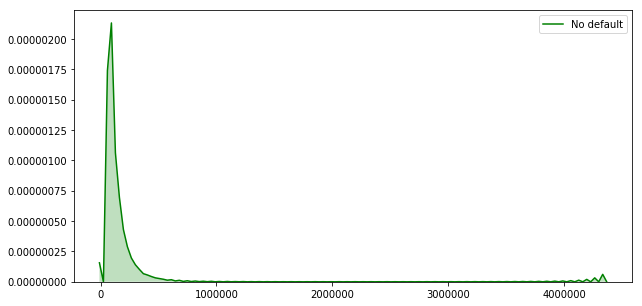

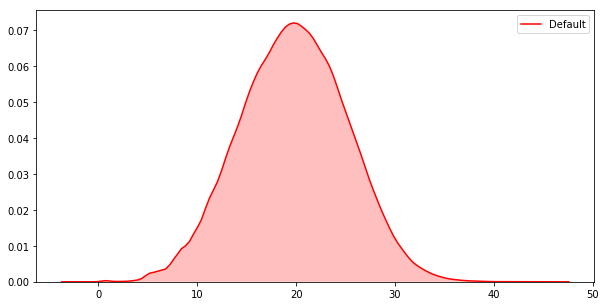

In [36]:
# признак 'donate_total' приводим к нормальному распределению
x_train['donate_total'], lmbd = box_cox(x_train['donate_total'])

In [37]:
# Тоже самое для тестового набора, но у с извесной lmbd
x_test['donate_total'] = boxcox(x_test['donate_total'], lmbd)

In [38]:
# Нормализуем данные
SCALER_FILE_PATH = 'scaler.pkl'
scaler = MinMaxScaler()
x_train[BASE_FEATURE_NAMES] = scaler.fit_transform(x_train[BASE_FEATURE_NAMES])
# Запомнаем модель нормализации
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [40]:
# Применяем нормализацию к тестовому DataSet
scaler = ''
with open(SCALER_FILE_PATH, 'rb') as file:
    scaler = pickle.load(file)
x_test[BASE_FEATURE_NAMES] = scaler.transform(x_test[BASE_FEATURE_NAMES])

In [47]:
# Классы не сбалансированы делаем балансировку
smote_enn = SMOTEENN(random_state=RND_STATE)
X_resampled, y_resampled = smote_enn.fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 262779), (1, 314501)]


In [48]:
# Сохраняем то, что получилось, ато долго обрабатывается
pd.DataFrame(x_train).to_csv('./dataset/x_train.csv', sep=';', index=False)
pd.DataFrame(x_test).to_csv('./dataset/x_test.csv', sep=';', index=False)
pd.DataFrame(y_train).to_csv('./dataset/y_train.csv', sep=';', index=False)
pd.DataFrame(y_test).to_csv('./dataset/y_test.csv', sep=';', index=False)
pd.DataFrame(X_resampled).to_csv('./dataset/x_train_balanced.csv', sep=';', index=False)
pd.DataFrame(y_resampled).to_csv('./dataset/y_train_balanced.csv', sep=';', index=False)

In [7]:
# Загужаем наборы для дальнейшей работы с ними
x_train =  pd.read_csv('./dataset/x_train.csv', sep=';', encoding='utf-8')
x_test = pd.read_csv('./dataset/x_test.csv', sep=';', encoding='utf-8')
y_train = pd.read_csv('./dataset/y_train.csv', sep=';', encoding='utf-8')
y_test = pd.read_csv('./dataset/y_test.csv', sep=';', encoding='utf-8')
X_resampled = pd.read_csv('./dataset/x_train_balanced.csv', sep=';', encoding='utf-8')
y_resampled = pd.read_csv('./dataset/y_train_balanced.csv', sep=';', encoding='utf-8')

In [8]:
TARGET_NAME = 'is_churned'
BASE_FEATURE_NAMES = x_train.columns.tolist()
RND_STATE = 42

In [7]:
# Применяем рекурсивный отсев признаков df[BASE_FEATURE_NAMES + [TARGET_NAME]
STEP = 5
logit = LogisticRegression(random_state=RND_STATE)
selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_resampled, y_resampled)
good_features = x_train.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 52


In [10]:
model_for_PL = catb.CatBoostClassifier(n_estimators=100, 
                                      max_depth=3, 
                                      silent=True,
                                      random_state=RND_STATE,
                                      l2_leaf_reg=2)
model_for_PL.fit(X_resampled, y_resampled)

In [11]:
# Ранжируем признаки при помощи PermutationImportance
perm = PermutationImportance(model_for_PL, random_state=RND_STATE).fit(X_resampled, y_resampled)
res = pd.DataFrame(X_resampled.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)
good_features_PL = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features_PL.shape[0])

Кол-во отобранных признаков: 30


In [12]:
pd.DataFrame(good_features_PL, index=range(len(good_features_PL))).to_csv('model_param.csv', sep=';', index=False)

Построим несколько моделей и сравни результаты из работы.

Логистическая регрессия

In [12]:
model_lr = LogisticRegression()
model_lr.fit(X_resampled[good_features], y_resampled)

y_train_pred_Line = model_lr.predict(X_resampled[good_features])
predict_proba_test_Line = model_lr.predict_proba(x_test[good_features])
y_test_pred_Line = model_lr.predict(x_test[good_features])

In [34]:
get_classification_report(y_resampled, y_train_pred_Line, y_test['is_churned'].values, y_test_pred_Line)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.86      0.83    262779
           1       0.87      0.83      0.85    314501

    accuracy                           0.84    577280
   macro avg       0.84      0.84      0.84    577280
weighted avg       0.84      0.84      0.84    577280

TEST

              precision    recall  f1-score   support

           0       0.99      0.79      0.88    104959
           1       0.11      0.80      0.19      3208

    accuracy                           0.79    108167
   macro avg       0.55      0.80      0.53    108167
weighted avg       0.97      0.79      0.86    108167

CONFUSION MATRIX

col_0      0      1
row_0              
0      83020  21939
1        631   2577


In [47]:
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, y_test_pred_Line, predict_proba_test_Line[:, 1])

Precision: 0.10511502692119432
Recall: 0.8033042394014963
F1: 0.18590390996970133
Log Loss: 0.6019213669173413
ROC AUC: 0.8457732702965668


Random Foresr

In [52]:
clf = RandomForestClassifier(n_estimators=100, 
                              max_depth=3, 
                              random_state=RND_STATE)
clf.fit(X_resampled[good_features_PL], y_resampled)

y_train_pred_K = clf.predict(X_resampled[good_features_PL])
predict_proba_K = clf.predict_proba(x_test[good_features_PL])
y_test_pred_K = clf.predict(x_test[good_features_PL])

get_classification_report(y_resampled, y_train_pred_K, y_test['is_churned'].values, y_test_pred_K)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.88      0.88    262779
           1       0.90      0.90      0.90    314501

    accuracy                           0.89    577280
   macro avg       0.89      0.89      0.89    577280
weighted avg       0.89      0.89      0.89    577280

TEST

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    104959
           1       0.12      0.82      0.21      3208

    accuracy                           0.81    108167
   macro avg       0.56      0.82      0.55    108167
weighted avg       0.97      0.81      0.87    108167

CONFUSION MATRIX

col_0      0      1
row_0              
0      85251  19708
1        567   2641


In [53]:
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, y_test_pred_K, predict_proba_K[:, 1])

Precision: 0.11817083538413352
Recall: 0.8232543640897756
F1: 0.2066752748757679
Log Loss: 0.4455103232986922
ROC AUC: 0.9012218023430072


CatBoost

In [55]:
model_catb = catb.CatBoostClassifier(n_estimators=100, 
                                      max_depth=3, 
                                      silent=True,
                                      random_state=RND_STATE,
                                      l2_leaf_reg=2)
model_catb.fit(X_resampled[good_features_PL], y_resampled)
y_train_pred_CGB = model_catb.predict(X_resampled[good_features_PL])
predict_proba_CGB = model_catb.predict_proba(x_test[good_features_PL])
y_test_pred_CGB = model_catb.predict(x_test[good_features_PL])

get_classification_report(y_resampled, y_train_pred_CGB, y_test['is_churned'].values, y_test_pred_CGB)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.93      0.95    262779
           1       0.95      0.97      0.96    314501

    accuracy                           0.95    577280
   macro avg       0.95      0.95      0.95    577280
weighted avg       0.95      0.95      0.95    577280

TEST

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    104959
           1       0.16      0.75      0.26      3208

    accuracy                           0.87    108167
   macro avg       0.57      0.81      0.60    108167
weighted avg       0.97      0.87      0.91    108167

CONFUSION MATRIX

col_0      0      1
row_0              
0      92214  12745
1        811   2397


In [56]:
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, y_test_pred_CGB, predict_proba_CGB[:, 1])

Precision: 0.15830141328754457
Recall: 0.7471945137157108
F1: 0.26125340599455044
Log Loss: 0.3123424016194203
ROC AUC: 0.8983261861614222


CatBoost показал наилучший результат, произведем подпор параметров при помощи GridSearch

In [57]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 9]}
cv=KFold(n_splits=3, random_state=RND_STATE, shuffle=True)

In [59]:
rs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_resampled[good_features_PL], y_resampled)
# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7feab515f090>,
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200, 500, 700, 1000, 1200,
                                          1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [60]:
# Параметры при которых модель должна показать наилучший результат
rs.best_params_

{'max_depth': 9, 'n_estimators': 1500}

In [61]:
rs.best_score_

0.9882929999068774

Проверим работу модели с отобранными параметрами

In [62]:
model_catb = catb.CatBoostClassifier(n_estimators=1500, 
                                      max_depth=9, 
                                      silent=True,
                                      random_state=RND_STATE,
                                      l2_leaf_reg=2)
model_catb.fit(X_resampled[good_features_PL], y_resampled)
y_train_pred_CGB = model_catb.predict(X_resampled[good_features_PL])
predict_proba_CGB = model_catb.predict_proba(x_test[good_features_PL])
y_test_pred_CGB = model_catb.predict(x_test[good_features_PL])

get_classification_report(y_resampled, y_train_pred_CGB, y_test['is_churned'].values, y_test_pred_CGB)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    262779
           1       0.99      0.99      0.99    314501

    accuracy                           0.99    577280
   macro avg       0.99      0.99      0.99    577280
weighted avg       0.99      0.99      0.99    577280

TEST

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    104959
           1       0.32      0.50      0.39      3208

    accuracy                           0.95    108167
   macro avg       0.65      0.73      0.68    108167
weighted avg       0.96      0.95      0.96    108167

CONFUSION MATRIX

col_0       0     1
row_0              
0      101543  3416
1        1611  1597


In [63]:
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, y_test_pred_CGB, predict_proba_CGB[:, 1])

Precision: 0.3185717135447836
Recall: 0.49781795511221943
F1: 0.38851721201800266
Log Loss: 0.12674004671789543
ROC AUC: 0.9182704303917841


Модель паказала результат намного лучше чем при первом построении.
Можем взять текущую модель для предсказаний.

In [79]:
# Объединяем тренировочный и тестовый наборы для финального обучения модели
x_all_values = X_resampled.copy()
x_all_values = x_all_values.append(x_test)
y_all_values = y_resampled.copy()
y_all_values = y_all_values.append(y_test)

In [81]:
# Обучаем модель на всем объеме
model_catb_final = catb.CatBoostClassifier(n_estimators=1500, 
                                      max_depth=9, 
                                      silent=True,
                                      random_state=RND_STATE,
                                      l2_leaf_reg=2)
model_catb_final.fit(x_all_values[good_features_PL], y_all_values)

In [82]:
# Запомнаем модель
MODEL_FILE_PATH = 'model_ctbs.pkl'
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb_final, file)

In [85]:
# Запомнаем показатели по которым работает модель
MODEL_PARAM_FILE_PATH = 'model_param.pkl'
with open(MODEL_PARAM_FILE_PATH, 'wb') as file:
    pickle.dump(good_features_PL, file)

In [44]:
# Для удобства объединим обработку набора данных в одной функции
def process_df(df):
    for index_row in df.index[df['user_id'] == 'user_id'].tolist():
        df.drop([index_row], inplace=True)
    df.loc[df['gender'] == 'M', 'gender'] = 0
    df.loc[df['gender'] == 'F', 'gender'] = 1
    df['user_id'] = df['user_id'].astype(str)
    for column in ['is_churned', 'level',               
                   'days_between_reg_fl',
                   'days_between_fl_df', 
                   'has_return_date', 
                   'has_phone_number'    
                  ]:
        df[column] = df[column].astype(int)
    for column in ['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'avg_min_ping_1', 'avg_min_ping_2',
                   'avg_min_ping_3', 'avg_min_ping_4', 'session_player_1', 'session_player_2', 'session_player_3',
                   'session_player_4', 'win_rate_1', 'win_rate_2', 'win_rate_3', 'win_rate_4', 'kd_1', 'kd_2', 'kd_3',
                   'kd_4', 'leavings_rate_1', 'leavings_rate_2', 'leavings_rate_3', 'leavings_rate_4', 'gold_spent_1',
                   'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'silver_spent_1', 'silver_spent_2',
                   'silver_spent_3', 'silver_spent_4', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
                   'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4',
                   'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
                   'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
                   'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
                   'age', 'gender', 'donate_total'
                    ]:
        df[column] = df[column].astype(float)
    # Заполняем возраст
    df['age'].fillna(method='pad',inplace=True)
    df['age'].fillna(method='bfill',inplace=True)
    df.loc[df['age'] > 100, 'age']  = df.loc[df['age'] > 100, 'age'] - 100
    df.loc[df['age'] > 50, 'age']  = df.loc[df['age'] > 50, 'age'] - 50
    df.loc[df['age'] < 7, 'age']  = df.loc[df['age'] < 7, 'age'] + 10
    # Заполняем пол
    df['gender'].fillna(method='pad',inplace=True)
    df['gender'].fillna(method='bfill',inplace=True)
    # убераем отрицательные значения их тут не может быть
    df.loc[df['gender'] < 0, 'gender'] = df.loc[df['gender'] < 0, 'gender'] * -1
    df.loc[df['avg_min_ping_1'] < 0, 'avg_min_ping_1']  = df.loc[df['avg_min_ping_1'] < 0, 'avg_min_ping_1'] * -1
    df.loc[df['avg_min_ping_2'] < 0, 'avg_min_ping_2']  = df.loc[df['avg_min_ping_2'] < 0, 'avg_min_ping_2'] * -1
    df.loc[df['avg_min_ping_3'] < 0, 'avg_min_ping_3']  = df.loc[df['avg_min_ping_3'] < 0, 'avg_min_ping_3'] * -1
    df.loc[df['avg_min_ping_4'] < 0, 'avg_min_ping_4']  = df.loc[df['avg_min_ping_4'] < 0, 'avg_min_ping_4'] * -1
    # для всех остальных признаков очень маловероятно, что какие-то данные потерялись,
    # следовательно если их нет, то игрок в этот день не заходил в игру или не совершал транзакций, заполняем 0
    df.fillna(0, inplace=True)
    for param in [
        'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
        'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4',
        'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
        'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
        'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
        'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4',
        'avg_min_ping_1', 'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4',
        'session_player_1', 'session_player_2', 'session_player_3', 'session_player_4',
        'gold_spent_1', 'gold_spent_2', 'gold_spent_3', 'gold_spent_4',
        'silver_spent_1', 'silver_spent_2', 'silver_spent_3', 'silver_spent_4'

    ]:
        df[param] = df[param].round(0)
        df[param] = df[param].astype(int)
    df.loc[df['days_between_reg_fl'] < 0, 'days_between_reg_fl']  = df.loc[df['days_between_reg_fl'] < 0, 'days_between_reg_fl'] * -1 
    df = df.loc[df['days_between_reg_fl'] == 0]
    df.drop(columns=['days_between_reg_fl'], axis=1, inplace=True)
    # Создадим новые параметры показывающие соотношений параметра 1 недели к 4
    param_list = ['trans_amt_', 'pay_amt_', 'reports_amt_', 'sess_with_abusers_amt_', 'session_amt_', 
                'disconnect_amt_', 'avg_min_ping_', 'session_player_', 'win_rate_', 'kd_', 'leavings_rate_',
                'gold_spent_', 'silver_spent_']
    pd.set_option('use_inf_as_na', True)
    for param in param_list:
        column = param + 'index'
        first_param = param + '4'
        second_param = param + '1'
        df[column] = df[first_param]/df[second_param]
    df.fillna(1, inplace=True)
    lmbd = 0.12074633661274975
    df.loc[df['donate_total'] == 0, 'donate_total'] = 0.000000001
    df['donate_total'] = boxcox(df['donate_total'], lmbd)
    user_id = df['user_id']
    # удаляем логины пользователей, они нам не нужны для предсказаний
    df.drop(columns=['user_id'], axis=1, inplace=True)
    return df, user_id

In [3]:
# Параметры для построения тестового DataSet
TARGET_NAME = 'is_churned'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_PARAM_FILE_PATH = 'model_param.pkl'
MODEL_FILE_PATH = 'model_ctbs.pkl'
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'
INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [92]:
# Строим тестовый DataSet
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='./test/',
                  dataset_path='./dataset/', 
                  mode='test')

Run time (reading csv files): 0:00:00.165510
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:00:02.182380
Processing with features: ['reports_amt']
Run time (calculating features): 0:00:08.268198
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:00:25.007867
Processing with features: ['disconnect_amt', 'session_amt']
Run time (calculating features): 0:00:44.266720
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:01:03.556580
Processing with features: ['leavings_rate', 'win_rate', 'kd', 'session_player']
Run time (calculating features): 0:01:22.985054
Processing with features: ['silver_spent', 'gold_spent']
Run time (calculating features): 0:01:43.250115
Dataset is successfully built and saved to ./dataset/, run time "build_dataset_raw": 0:01:44.799035
Processing with features: ['trans_amt', 'pay_

In [45]:
# Загружаем тестовый DataSet
df = pd.read_csv('./dataset/dataset_raw_train.csv', sep=';', encoding='utf-8')

In [46]:
# Производим обработку
processed_df, user_id = process_df(df)

In [49]:
# Нормализуем данные
scaler = ''
BASE_FEATURE_NAMES = processed_df.columns.drop(TARGET_NAME).tolist()
with open(SCALER_FILE_PATH, 'rb') as file:
    scaler = pickle.load(file)
processed_df[BASE_FEATURE_NAMES] = scaler.transform(processed_df[BASE_FEATURE_NAMES])

In [14]:
# Загружаем показатели
model_param = pd.read_csv('model_param.csv', sep=';', encoding='utf-8')

In [17]:
# Загружаем модель
model_catb_final = ''
with open(MODEL_FILE_PATH, 'rb') as file:
    model_catb_final = pickle.load(file)

In [50]:
# Выполняем предсказание
final_predict = model_catb_final.predict(processed_df[good_features_PL])

In [80]:
# Объединяем результаты предсказаний с user_id
result = pd.DataFrame(user_id.values, index=range(len(final_predict)))
result.columns = ['user_id']
result[TARGET_NAME] = pd.DataFrame(final_predict, index=range(len(final_predict)))

In [82]:
result.to_csv('./dataset/BudzinAV_predict.csv', sep=';', index=False)